In [332]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Synthetic Circle

## Description of the Problem

This is a dataset given which has 100 circles made up of 10000 points. The data has 3 columns 'x', 'y' and 'z'. This dataset is primarly created to gauge how well do clustering algorithms perform on this task. We will begin with Exploratory Data Analysis and then proceed with Preprocessing and Analysis of results. 

In [333]:
df = pd.read_csv('circles.csv') 

In [334]:
df.head()

x          y  class
0    3.15676  116.12252      6
1   16.14436   16.81660     11
2  100.31212   64.99025     53
3   -1.33773   84.81772      4
4  104.37328   62.42373     53

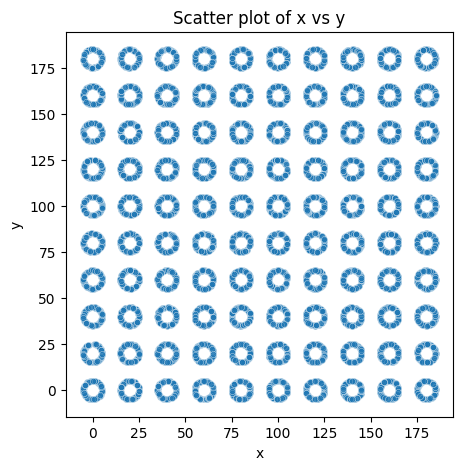

In [335]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x='x', y='y', s=20, color='tab:blue', alpha=0.7)
plt.title('Scatter plot of x vs y')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Plotted graph to verify that the "dataset comprises ... points arranged into 100 circles"

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       10000 non-null  float64
 1   y       10000 non-null  float64
 2   class   10000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 234.5 KB


$1000$ non-null data rows. $x,y \in$ float and class $\in$ int

In [337]:
df.describe()

x             y         class
count  10000.000000  10000.000000  10000.000000
mean      89.981670     90.003827     49.500000
std       57.457467     57.559719     28.867513
min       -5.000000     -4.999860      0.000000
25%       40.237885     40.133840     24.750000
50%       89.999995     90.000080     49.500000
75%      139.898800    139.977695     74.250000
max      184.999920    185.000000     99.000000

In [338]:
print(df.isnull().sum())
df[df.duplicated(keep=False)]

x        0
y        0
class    0
dtype: int64


Empty DataFrame
Columns: [x, y, class]
Index: []

No null entries and no duplicate rows with duplicates

In [339]:
# #data normalization (Z-score Normalization) 
# for col in ['x','y']:
#     mean = df[col].mean()
#     std = df[col].std()
#     df[col] = (df[col] - mean) / std

Performed z-score normalization. Rationale for choosing z-score instead of min-max or other normalization techniques is prior experience with several clustering examples is Z-score preserves the data much better than other normalization techinques doesnt alter the underlying distribution too much. 

In [340]:
df.head()

x          y  class
0    3.15676  116.12252      6
1   16.14436   16.81660     11
2  100.31212   64.99025     53
3   -1.33773   84.81772      4
4  104.37328   62.42373     53

### Dimensionality Reduction

In this section we will proceed to reduce the dimension of this to 1 as specified by the document as it wanted us to reduce dimensions so we capture x,y is captured in PC1 in z.


In [341]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
df['z'] = pca.fit_transform(df[['x','y', 'class']])
df.head()



x          y  class           z
0    3.15676  116.12252      6  -94.202441
1   16.14436   16.81660     11  -89.820473
2  100.31212   64.99025     53    8.382456
3   -1.33773   84.81772      4 -102.058207
4  104.37328   62.42373     53   11.748846

### Kmeans Clustering Algorithm 

Let us now impliment the Kmeans Clustering method. Prelimnarily we need a function which can compute the euclidean distances very quickly. We will be using python's Numpy library to speed up a lot of operations. So we begin this by randomly sampling k centroids from a uniform distribution and then we iterate and recompute which points belong to which other cluster compared to initial clusters and keep iterating till we reach convergence or reach max iteration. Max iteration is built to prevent infinite loops. 

We impliment this in the class Kmeans, which contains all the necessery functions for the Kmeans clustering implimentation. It is also speed up by using numpy array vectorizations as matrix multiplications are quicker than forloops because they use cython. We also have one of the metrics to see quality of our clusters Silhoutte score. 

In [342]:
#Kmeans Clustering algorithm 
def euclidean_distance(point, data):
    return np.sqrt(np.sum((point - data) ** 2))

class KMeans: 
    #initialize k and max iterations (to prevent infinite loops)
    def __init__(self, k, max_iter=100):
        self.k = k
        self.max_iter = max_iter
    
    #Main Clustering function
    def fit(self, data):


        #initalize k random centroids from a unifrom distribution
        min_c, max_c = np.min(data, axis=0), np.max(data, axis=0)
        self.centroids = [np.random.uniform(min_c, max_c) for _ in range(self.k)]
        self.centroids = np.array(self.centroids) 
         
        #iter to refine centroids
        curr_iter = 0
        prev_centroids = None
        
        pbar = tqdm(total=self.max_iter, desc="Clustering Progress")
        while (prev_centroids is None or np.not_equal(prev_centroids, self.centroids).any()) and curr_iter < self.max_iter:

            #calccculate all squared distances from N points to K centroids
            diff = data[:, np.newaxis] - self.centroids
            sqr_dists = np.sum(diff**2, axis=2)
            
            #assign each point to the closest centroid
            labels = np.argmin(sqr_dists, axis=1)
            prev_centroids = np.copy(self.centroids)
            
            for i in range(self.k):
                clustered_pts = data[labels == i]
                if len(clustered_pts) > 0:
                    self.centroids[i] = np.mean(clustered_pts, axis=0)
                else:
                    self.centroids[i] = prev_centroids[i]

            curr_iter += 1
            pbar.update(1)
        pbar.close()

class Eval: 
    @staticmethod
    def silhouette_score(data, labels):
        labels = np.array(labels)
        silhouette_scores = []
        unique_labels = np.unique(labels)
        
        for i, point in tqdm(enumerate(data), total=len(data), desc="Silhouette Score Progress"):
            #points in same cluster
            same_cluster_mask = labels == labels[i]
            same_clustered_pts = data[same_cluster_mask]
            
            #calculate intracluster distance a
            if len(same_clustered_pts) > 1:
                a = np.mean([euclidean_distance(point, p) for p in same_clustered_pts if not np.array_equal(p, point)])
            else:
                a = 0
            
            #calculate intercluster distance b
            b = np.inf
            for cluster_label in unique_labels:
                if cluster_label != labels[i]:
                    other_cluster_mask = labels == cluster_label
                    other_clustered_pts = data[other_cluster_mask]
                    if len(other_clustered_pts) > 0:
                        mean_dist = np.mean([euclidean_distance(point, p) for p in other_clustered_pts])
                        b = min(b, mean_dist)
            
            #calculate silhouette score for this point
            if max(a, b) > 0:
                silhouette_scores.append((b - a) / max(a, b))
            else:
                silhouette_scores.append(0)
        
        return np.mean(silhouette_scores)

In [343]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

X = df[['z']].values 
kmeans = KMeans(k=100, max_iter=200)
kmeans.fit(X)
# assign points to nearest centroids
distances = np.linalg.norm(X[:, np.newaxis] - kmeans.centroids, axis=2)
labels_sk = np.argmin(distances, axis=1)

db = DBSCAN(eps=0.09, min_samples=3)
labels_db = db.fit_predict(X)

n_noise = int((labels_db == -1).sum())
unique_labels = set(labels_db)
n_clusters = len(unique_labels - {-1})

print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points")

# compute silhouette score excluding noise points
mask = labels_db != -1
if n_clusters >= 2 and mask.sum() > 0:
    S_db = silhouette_score(X[mask], labels_db[mask])
    print(f"DBSCAN Silhouette Score (excluding noise): {S_db:.6f}")
else:
    print("Silhouette score cannot be computed: need at least 2 clusters (excluding noise).")

# compute sklearn silhouette score
S_sk = silhouette_score(X, labels_sk)
print(f"Sklearn Silhouette Score: {S_sk:.6f}")
# score = kmeans.silhouette_score(df[['x','y']].values)
# print(f'Silhouette Score: {score}')





Clustering Progress:  29%|██▉       | 58/200 [00:00<00:00, 206.64it/s]



DBSCAN found 253 clusters and 51 noise points
DBSCAN Silhouette Score (excluding noise): 0.361874
DBSCAN Silhouette Score (excluding noise): 0.361874
Sklearn Silhouette Score: 0.549068
Sklearn Silhouette Score: 0.549068


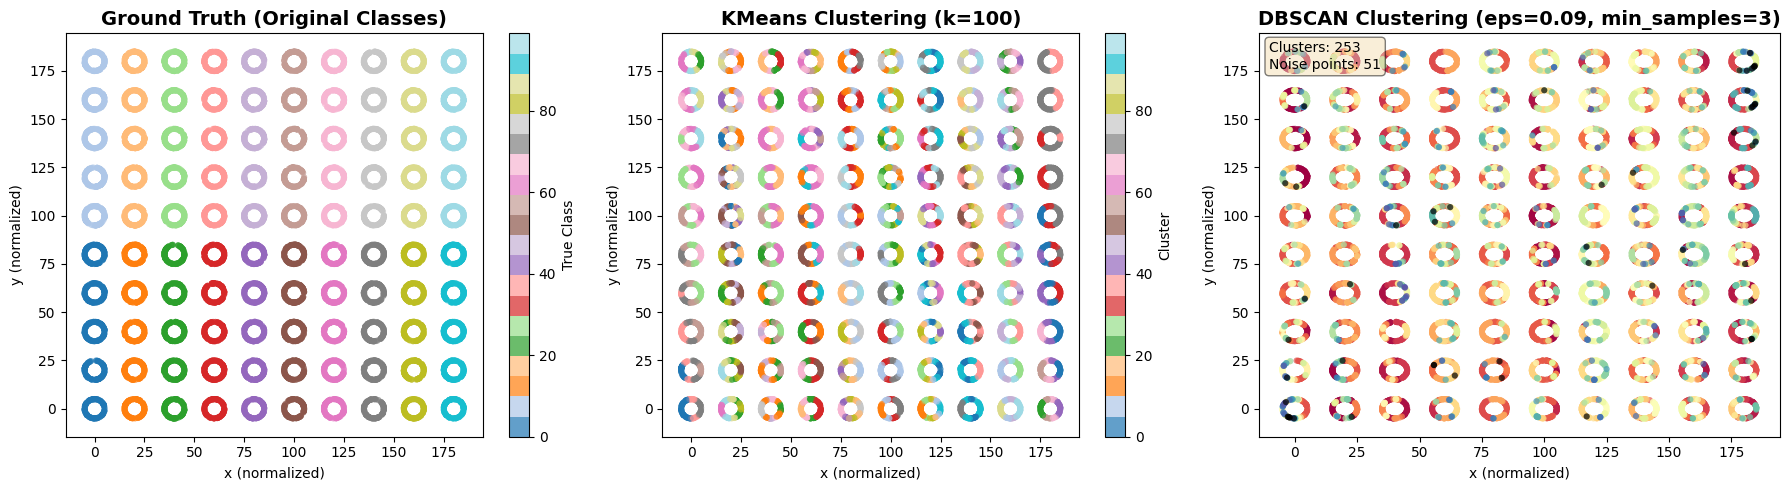


Clustering Summary:
  Ground Truth: 100 classes
  KMeans: 100 clusters
  DBSCAN: 253 clusters + 51 noise points


In [344]:
# Visualize clustering results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original data with true labels
ax1 = axes[0]
scatter1 = ax1.scatter(df['x'], df['y'], c=df['class'], cmap='tab20', s=20, alpha=0.7, edgecolors='none')
ax1.set_title('Ground Truth (Original Classes)', fontsize=14, fontweight='bold')
ax1.set_xlabel('x (normalized)')
ax1.set_ylabel('y (normalized)')
plt.colorbar(scatter1, ax=ax1, label='True Class')

# KMeans clustering results
ax2 = axes[1]
scatter2 = ax2.scatter(df['x'], df['y'], c=labels_sk, cmap='tab20', s=20, alpha=0.7, edgecolors='none')
ax2.set_title(f'KMeans Clustering (k={kmeans.k})', fontsize=14, fontweight='bold')
ax2.set_xlabel('x (normalized)')
ax2.set_ylabel('y (normalized)')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

# DBSCAN clustering results
ax3 = axes[2]
# Create color map - noise points in black
unique_labels_db = set(labels_db)
colors_db = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_db))]

for k, col in zip(unique_labels_db, colors_db):
    if k == -1:
        # Black for noise
        col = [0, 0, 0, 1]
    
    class_member_mask = (labels_db == k)
    xy = df[['x', 'y']].values[class_member_mask]
    ax3.scatter(xy[:, 0], xy[:, 1], c=[col], s=20, alpha=0.7, edgecolors='none', 
                label='Noise' if k == -1 else f'Cluster {k}')

ax3.set_title(f'DBSCAN Clustering (eps={db.eps}, min_samples={db.min_samples})', 
              fontsize=14, fontweight='bold')
ax3.set_xlabel('x (normalized)')
ax3.set_ylabel('y (normalized)')

# Add summary text
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_db = list(labels_db).count(-1)
textstr = f'Clusters: {n_clusters_db}\nNoise points: {n_noise_db}'
ax3.text(0.02, 0.98, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nClustering Summary:")
print(f"  Ground Truth: {len(df['class'].unique())} classes")
print(f"  KMeans: {len(set(labels_sk))} clusters")
print(f"  DBSCAN: {n_clusters_db} clusters + {n_noise_db} noise points")

In [345]:
# Compare clustering results with true labels using NMI
from sklearn.metrics import normalized_mutual_info_score

# Get true labels from the dataset
true_labels = df['class'].values

# Get predicted labels from KMeans
distances = np.linalg.norm(X[:, np.newaxis] - kmeans.centroids, axis=2)
predicted_labels = np.argmin(distances, axis=1)

# Calculate NMI
nmi_score = normalized_mutual_info_score(true_labels, predicted_labels)
print(f"Normalized Mutual Information (NMI): {nmi_score:.6f}")
print(f"NMI ranges from 0 (no mutual information) to 1 (perfect correlation)")
print(f"\nInterpretation:")
if nmi_score > 0.7:
    print("- Strong agreement between clustering and true labels")
elif nmi_score > 0.4:
    print("- Moderate agreement between clustering and true labels")
else:
    print("- Weak agreement between clustering and true labels")

Normalized Mutual Information (NMI): 0.670362
NMI ranges from 0 (no mutual information) to 1 (perfect correlation)

Interpretation:
- Moderate agreement between clustering and true labels


## Results (Avi take a look)

After Normalization and dim reduction: 
Kmeans gets a silhoutte score of 0.7 - 0.74 and a NMI of 0.65 basically showing it captures around 70 clusters  wheras DBscans captures 100 clusters with no noise (perfect captures) This is expected as afternormalizaiton the structure of circles gets destoryed as we are mapping x and y to a value between 0 and 1 thus the density represnetation changes while k means which expects circles fails. 

No normalization and yes dim reduction:
Kmeans as expected gets 100 percent of the 

In [346]:
# from sklearn.cluster import KMeans as SKKMeans
# from sklearn.metrics import silhouette_score
# # X = your feature array, shape (n_points, 2)
# k = 100  # same as your custom KMeans

# sk_kmeans = SKKMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
# sk_kmeans.fit(X)

# # Get cluster labels
# labels_sk = sk_kmeans.labels_
# S_sk = silhouette_score(X, labels_sk)
# print(f"Sklearn KMeans Silhouette Score: {S_sk:.4f}")

In [347]:
#DBscan Algorithm

def euclidean_distance(point, data):
    return np.sqrt(np.sum((point - data) ** 2))

def neighbours(X, point_idx, eps):
    dist = [euclidean_distance(X[point_idx], X[i]) for i in range(len(X))]
    return [i for i, d in enumerate(dist) if d <= eps]

def findpts(X, eps, min_pts):
    core_pts = []
    for i in tqdm(range(len(X))):
        if len(neighbours(X, i, eps)) >= min_pts:
            core_pts.append(i)
    return core_pts

def expand_cluster(X, labels, points_idx, neighbours_list, cluster_id, eps, min_pts):
    labels[points_idx] = cluster_id
    i = 0
    while i < len(neighbours_list):
        neigh = neighbours_list[i]
        if labels[neigh] == -1:
            labels[neigh] = cluster_id
        elif labels[neigh] == 0:
            labels[neigh] = cluster_id
            new_neighbours = neighbours(X, neigh, eps)
            if len(new_neighbours) >= min_pts:
                neighbours_list.extend(new_neighbours)
        i += 1
    return labels

def dbscan(X, eps, min_pts):
    labels = np.zeros(len(X))
    cluster_id = 0
    core_pts = findpts(X, eps, min_pts)
    
    for point_idx in tqdm(range(len(X)), desc="DBSCAN clustering"):
        if labels[point_idx] != 0:
            continue
        if point_idx in core_pts:
            cluster_id += 1
            new_neighbours = neighbours(X, point_idx, eps)
            labels = expand_cluster(X, labels, point_idx, new_neighbours, cluster_id, eps, min_pts)
        else:
            labels[point_idx] = -1 
    return labels



# Bank Marketing

## About the Dataset

The dataset is captured by a Portuguese banking institution for the purpose of improving their direct marketing campaign. The classification goal is to predict if the client will subscribe to a term deposit.

The about section of the dataset provides other key insights that guides our data exploration and pre-processing. The datasets we have considered (as per the question) is the one with 17 features split into a complete csv dataset with all the data points (total 45211) and another csv dataset with a 10% randomly selected sample.

The data-types are either Categorical or Integer. The categorical data-types will need to be encoded with one-hot encoding. The about section also mentions that some features have missing values which means they will either need to be dropped or we need to impute the value.

In [348]:
# Load the bank marketing dataset properly
import re

def parse_bank_csv_line(line):
    # Remove outer quotes and split by semicolon, then clean inner quotes
    line = line.strip().strip('"')  
    parts = line.split(';')
    cleaned_parts = []
    for part in parts:
        # Remove double quotes around values
        part = part.strip('""')
        cleaned_parts.append(part)
    return cleaned_parts

# Read and parse the file
data = []
with open('bank_marketing/bank-full.csv', 'r', encoding='utf-8') as f:
    for line in f:
        parsed_line = parse_bank_csv_line(line.strip())
        data.append(parsed_line)

# Create DataFrame
columns = data[0]  # First row is header
df_bank = pd.DataFrame(data[1:], columns=columns)

In [349]:
df_bank.head()

age           job  marital  education default balance housing loan  contact  \
0  58    management  married   tertiary      no    2143     yes   no  unknown   
1  44    technician   single  secondary      no      29     yes   no  unknown   
2  33  entrepreneur  married  secondary      no       2     yes  yes  unknown   
3  47   blue-collar  married    unknown      no    1506     yes   no  unknown   
4  33       unknown   single    unknown      no       1      no   no  unknown   

  day month duration campaign pdays previous poutcome   y  
0   5   may      261        1    -1        0  unknown  no  
1   5   may      151        1    -1        0  unknown  no  
2   5   may       76        1    -1        0  unknown  no  
3   5   may       92        1    -1        0  unknown  no  
4   5   may      198        1    -1        0  unknown  no

In [350]:
df.isnull().sum().sum()

np.int64(0)

In [351]:
# how many occurances of "unknown" in entire df_bank
total_unknowns = sum((df_bank[col] == "unknown").sum() for col in df_bank.columns)
total_unknowns

np.int64(52124)

In [352]:
# converting integer columns to int
integer_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Convert columns to integers
for col in integer_columns:
    if col in df_bank.columns:
        df_bank[col] = pd.to_numeric(df_bank[col], errors='coerce').astype('Int64')  # Use Int64 to handle NaN values

df.dtypes

x        float64
y        float64
class      int64
z        float64
dtype: object

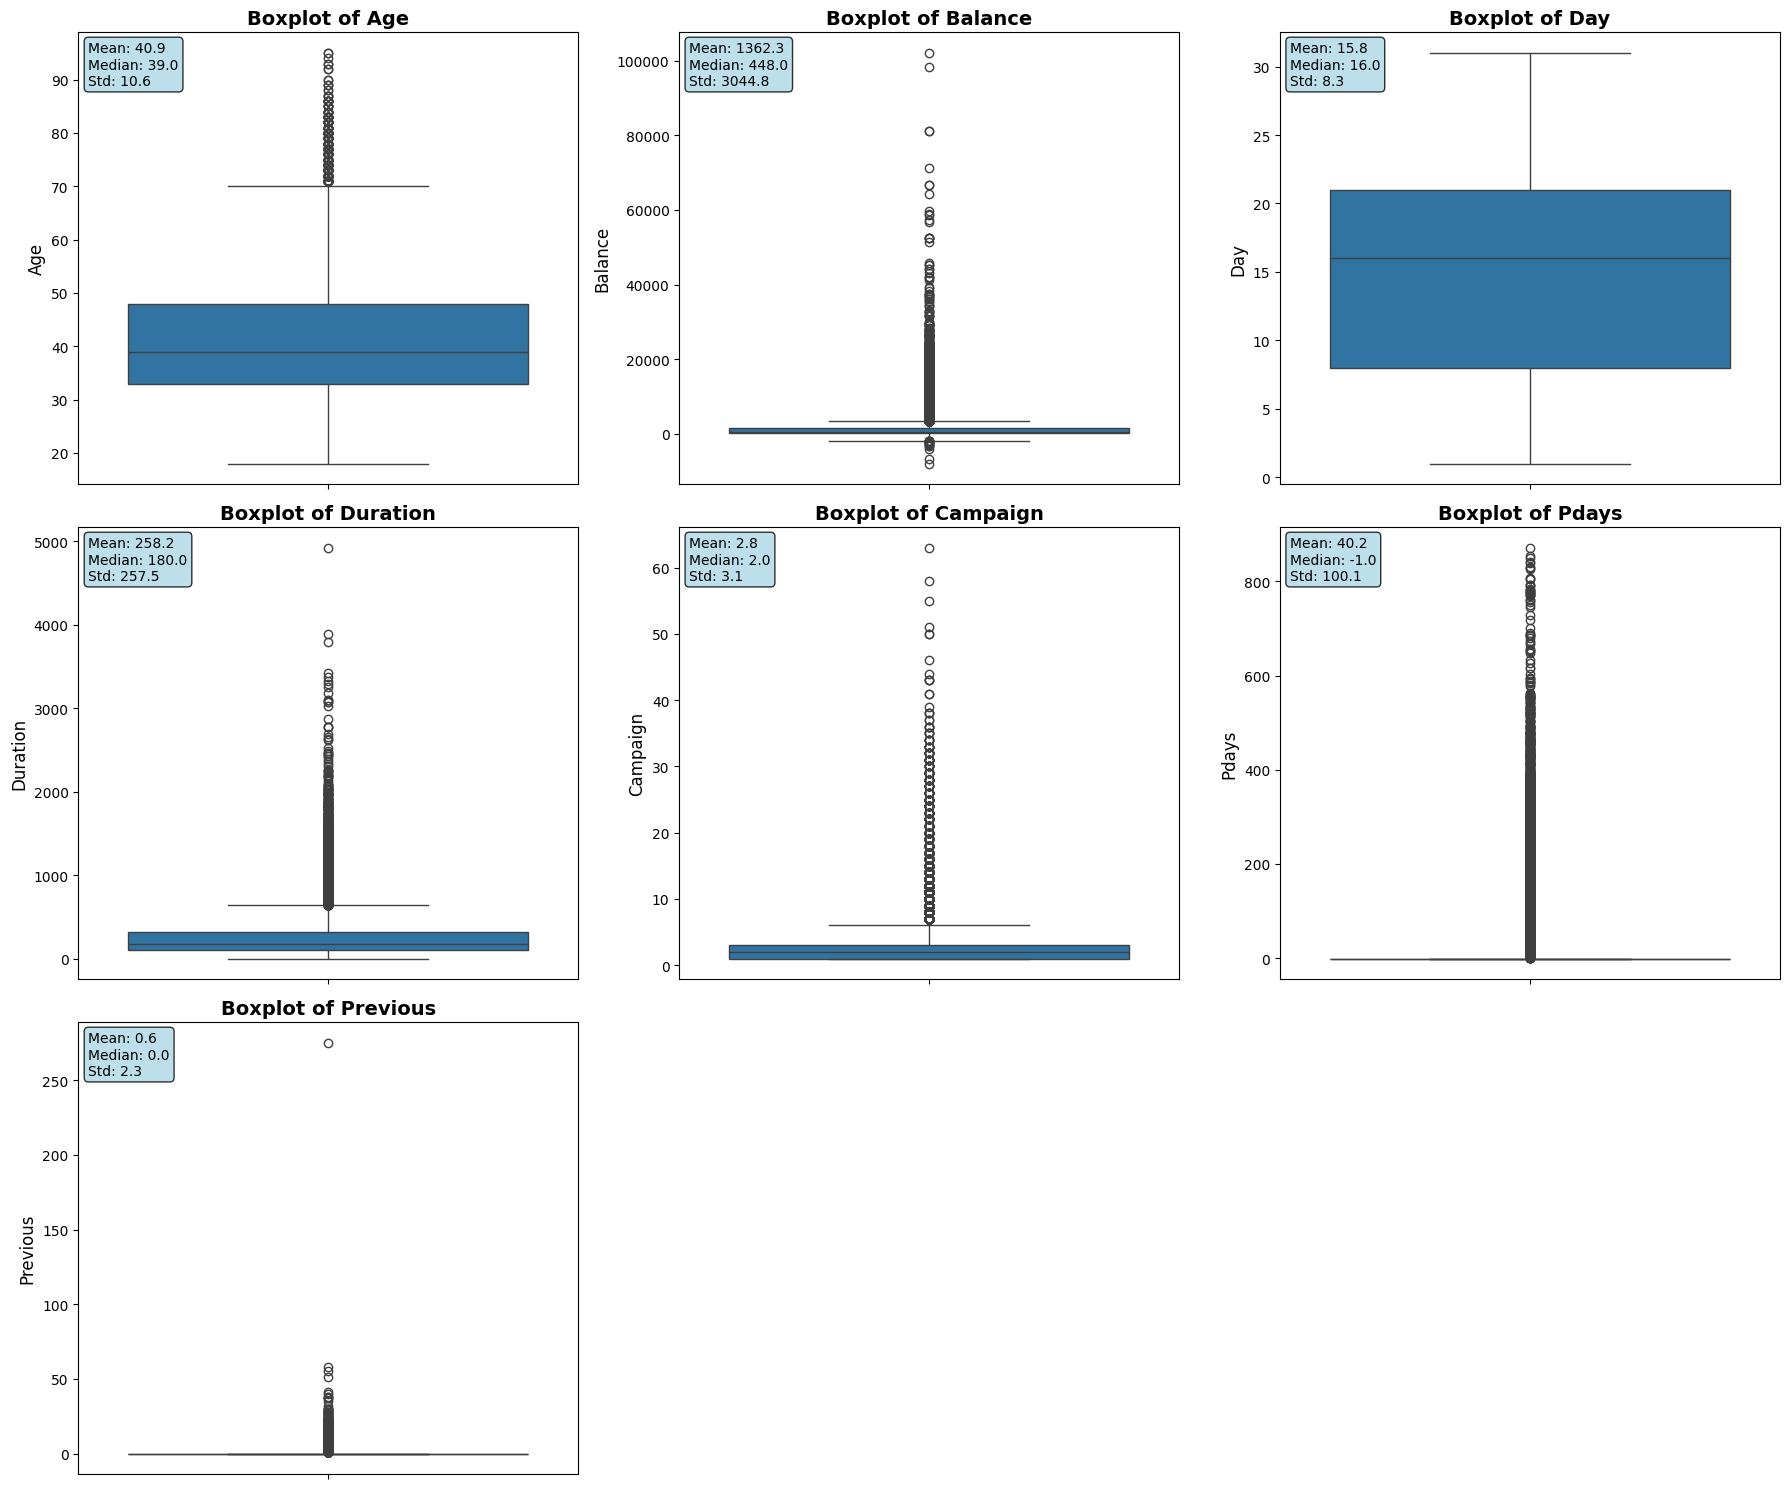

In [353]:
# Create a subplot grid
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(integer_columns):
    if i < len(axes):
        sns.boxplot(data=df_bank, y=col, ax=axes[i])
        axes[i].set_title(f'Boxplot of {col.title()}', fontsize=14, fontweight='bold')
        axes[i].set_ylabel(col.title(), fontsize=12)
        
        # Add statistics text
        mean_val = df_bank[col].mean()
        median_val = df_bank[col].median()
        std_val = df_bank[col].std()
        
        stats_text = f'Mean: {mean_val:.1f}\nMedian: {median_val:.1f}\nStd: {std_val:.1f}'
        axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                    verticalalignment='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Hide unused subplots
for j in range(len(integer_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

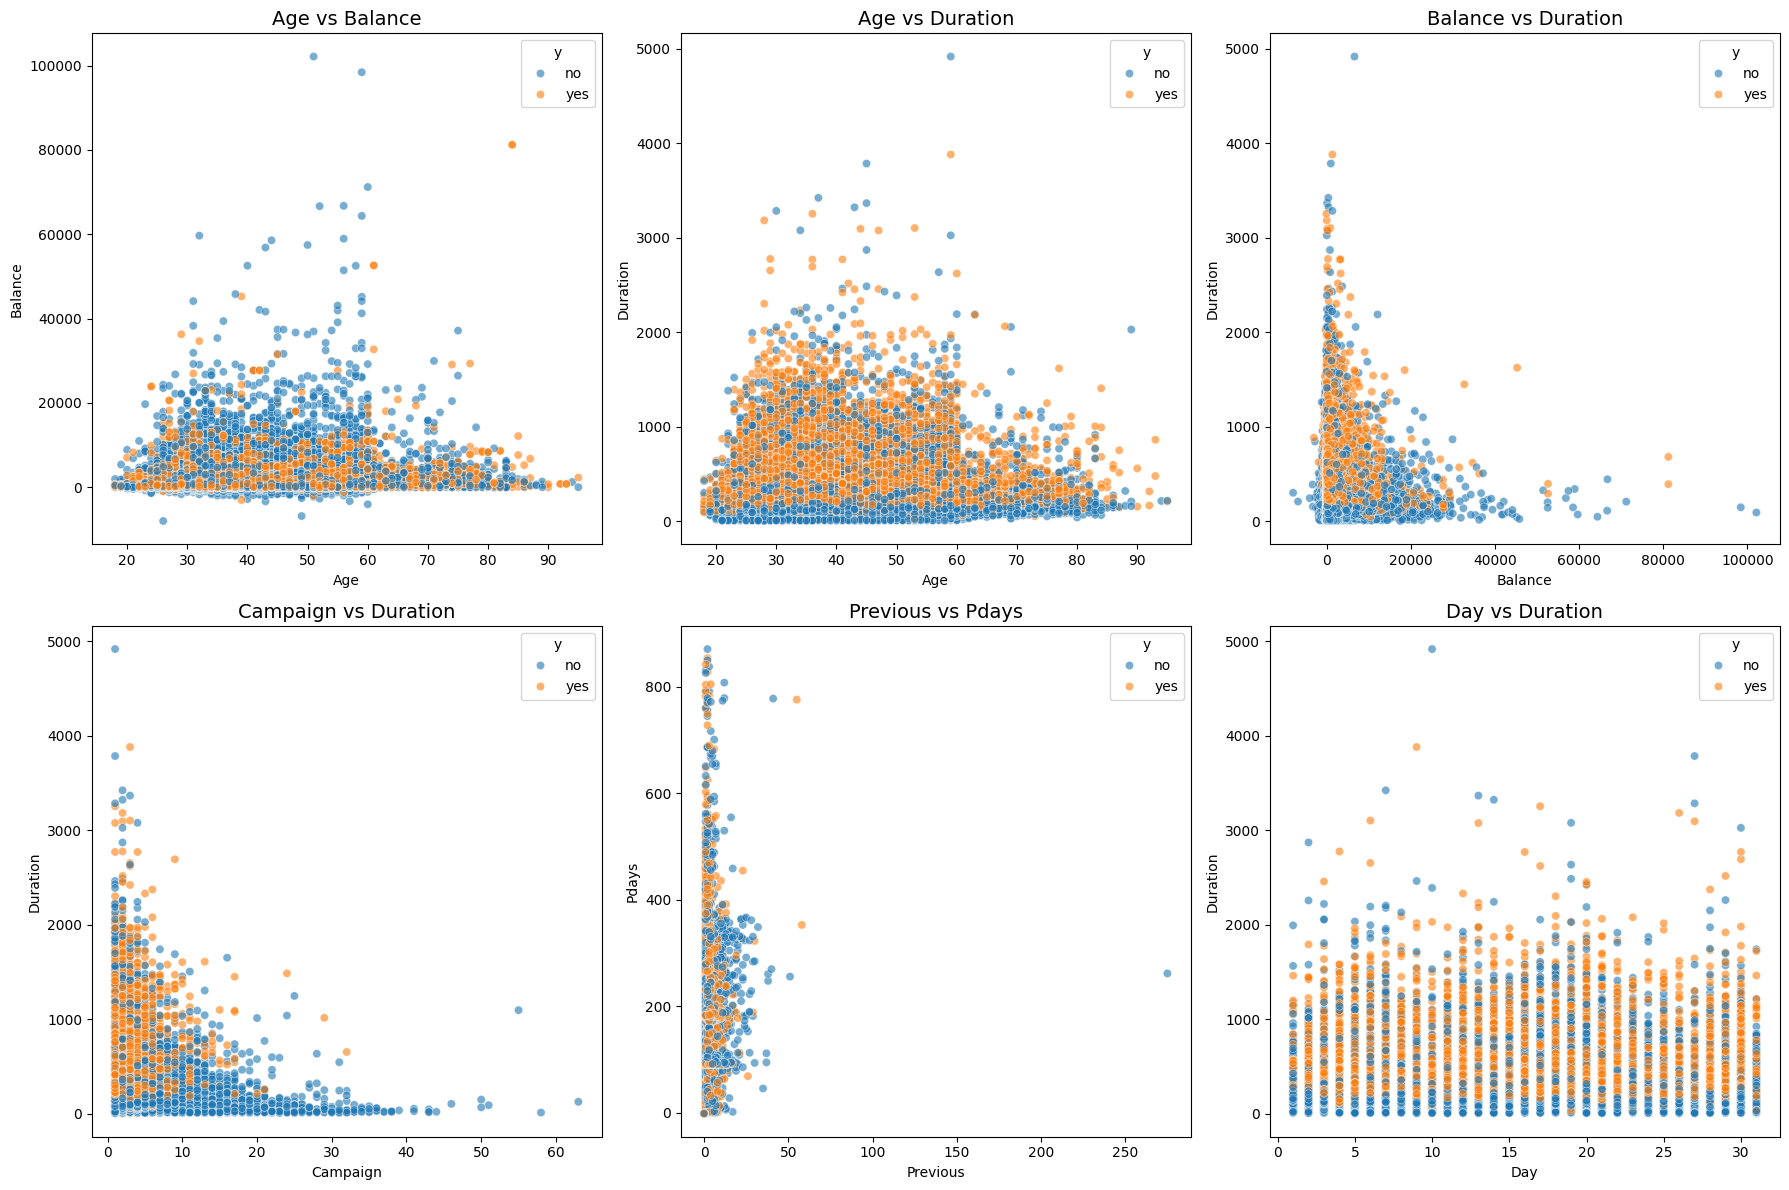

Scatter plots showing relationships between numeric variables.
Points are colored by subscription outcome (y): 'yes' vs 'no'


In [354]:
# Create scatter plots to explore relationships between numeric variables
integer_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create scatter plots for interesting relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define interesting relationships to plot
relationships = [
    ('age', 'balance'),
    ('age', 'duration'),
    ('balance', 'duration'),
    ('campaign', 'duration'),
    ('previous', 'pdays'),
    ('day', 'duration')
]

for i, (x_col, y_col) in enumerate(relationships):
    if i < len(axes):
        # Color by target variable 'y' if you want to see subscription patterns
        sns.scatterplot(data=df_bank, x=x_col, y=y_col, hue='y', ax=axes[i], alpha=0.6)
        axes[i].set_title(f'{x_col.title()} vs {y_col.title()}', fontsize=14)
        axes[i].set_xlabel(x_col.title())
        axes[i].set_ylabel(y_col.title())

plt.tight_layout()
plt.show()

print("Scatter plots showing relationships between numeric variables.")
print("Points are colored by subscription outcome (y): 'yes' vs 'no'")

In [355]:
# Z-score based outlier removal (BEFORE normalization)
print(f"Original dataset shape: {df_bank.shape}")

# Store original data before outlier removal
original_rows = len(df_bank)

# Remove outliers using Z-score threshold (typically 3 or 2.5)
outlier_threshold = 3
total_outliers_removed = 0

# Create a mask to track which rows to keep
keep_mask = pd.Series([True] * len(df_bank), index=df_bank.index)

for col in integer_columns:
    if col in df_bank.columns:
        # Calculate z-scores for original data (not normalized)
        mean_val = df_bank[col].mean()
        std_val = df_bank[col].std()
        
        # Handle case where std is 0 (all values same)
        if std_val == 0:
            print(f"{col}: No outliers (std=0)")
            continue
            
        z_scores = np.abs((df_bank[col] - mean_val) / std_val)
        
        # Count outliers before removal
        col_outliers_mask = z_scores > outlier_threshold
        col_outliers = col_outliers_mask.sum()
        total_outliers_removed += col_outliers
        
        # Update keep mask - keep only rows that are NOT outliers in this column
        keep_mask = keep_mask & (~col_outliers_mask)
        
        print(f"{col}: {col_outliers} outliers detected ({col_outliers/original_rows*100:.2f}%)")

# Apply the combined mask to remove outliers
df_bank = df_bank[keep_mask].copy()

# Reset index after outlier removal
df_bank = df_bank.reset_index(drop=True)

# print(f"\nOutlier Removal Summary:")
# print(f"  Rows removed: {original_rows - len(df_bank)} ({(original_rows - len(df_bank))/original_rows*100:.2f}%)")
# print(f"  Final dataset shape: {df_bank.shape}")
# print(f"  Data retained: {len(df_bank)/original_rows*100:.2f}%")

# # Verify data integrity
# print(f"\nData integrity check:")
# print(f"  No null values: {df_bank.isnull().sum().sum() == 0}")
# print(f"  All columns present: {len(df_bank.columns) == 17}")  # Should be 17 original columns

Original dataset shape: (45211, 17)
age: 381 outliers detected (0.84%)
balance: 745 outliers detected (1.65%)
day: 0 outliers detected (0.00%)
duration: 963 outliers detected (2.13%)
campaign: 840 outliers detected (1.86%)
pdays: 1723 outliers detected (3.81%)
previous: 582 outliers detected (1.29%)


In [356]:
# Z-score Normalization for integer columns
for col in integer_columns:
    mean = df_bank[col].mean()
    std = df_bank[col].std()
    df_bank[col] = (df_bank[col] - mean) / std

df_bank.head()

age           job  marital  education default   balance housing loan  \
0  1.719131    management  married   tertiary      no  0.614998     yes   no   
1  0.331158    technician   single  secondary      no -0.612057     yes   no   
2 -0.759393  entrepreneur  married  secondary      no -0.627729     yes  yes   
3  0.628581   blue-collar  married    unknown      no  0.245257     yes   no   
4 -0.759393       unknown   single    unknown      no -0.628309      no   no   

   contact       day month  duration  campaign     pdays  previous poutcome  \
0  unknown -1.293667   may  0.132375   -0.7504 -0.364873 -0.333651  unknown   
1  unknown -1.293667   may -0.445331   -0.7504 -0.364873 -0.333651  unknown   
2  unknown -1.293667   may -0.839221   -0.7504 -0.364873 -0.333651  unknown   
3  unknown -1.293667   may -0.755191   -0.7504 -0.364873 -0.333651  unknown   
4  unknown -1.293667   may -0.198493   -0.7504 -0.364873 -0.333651  unknown   

    y  
0  no  
1  no  
2  no  
3  no  
4  no

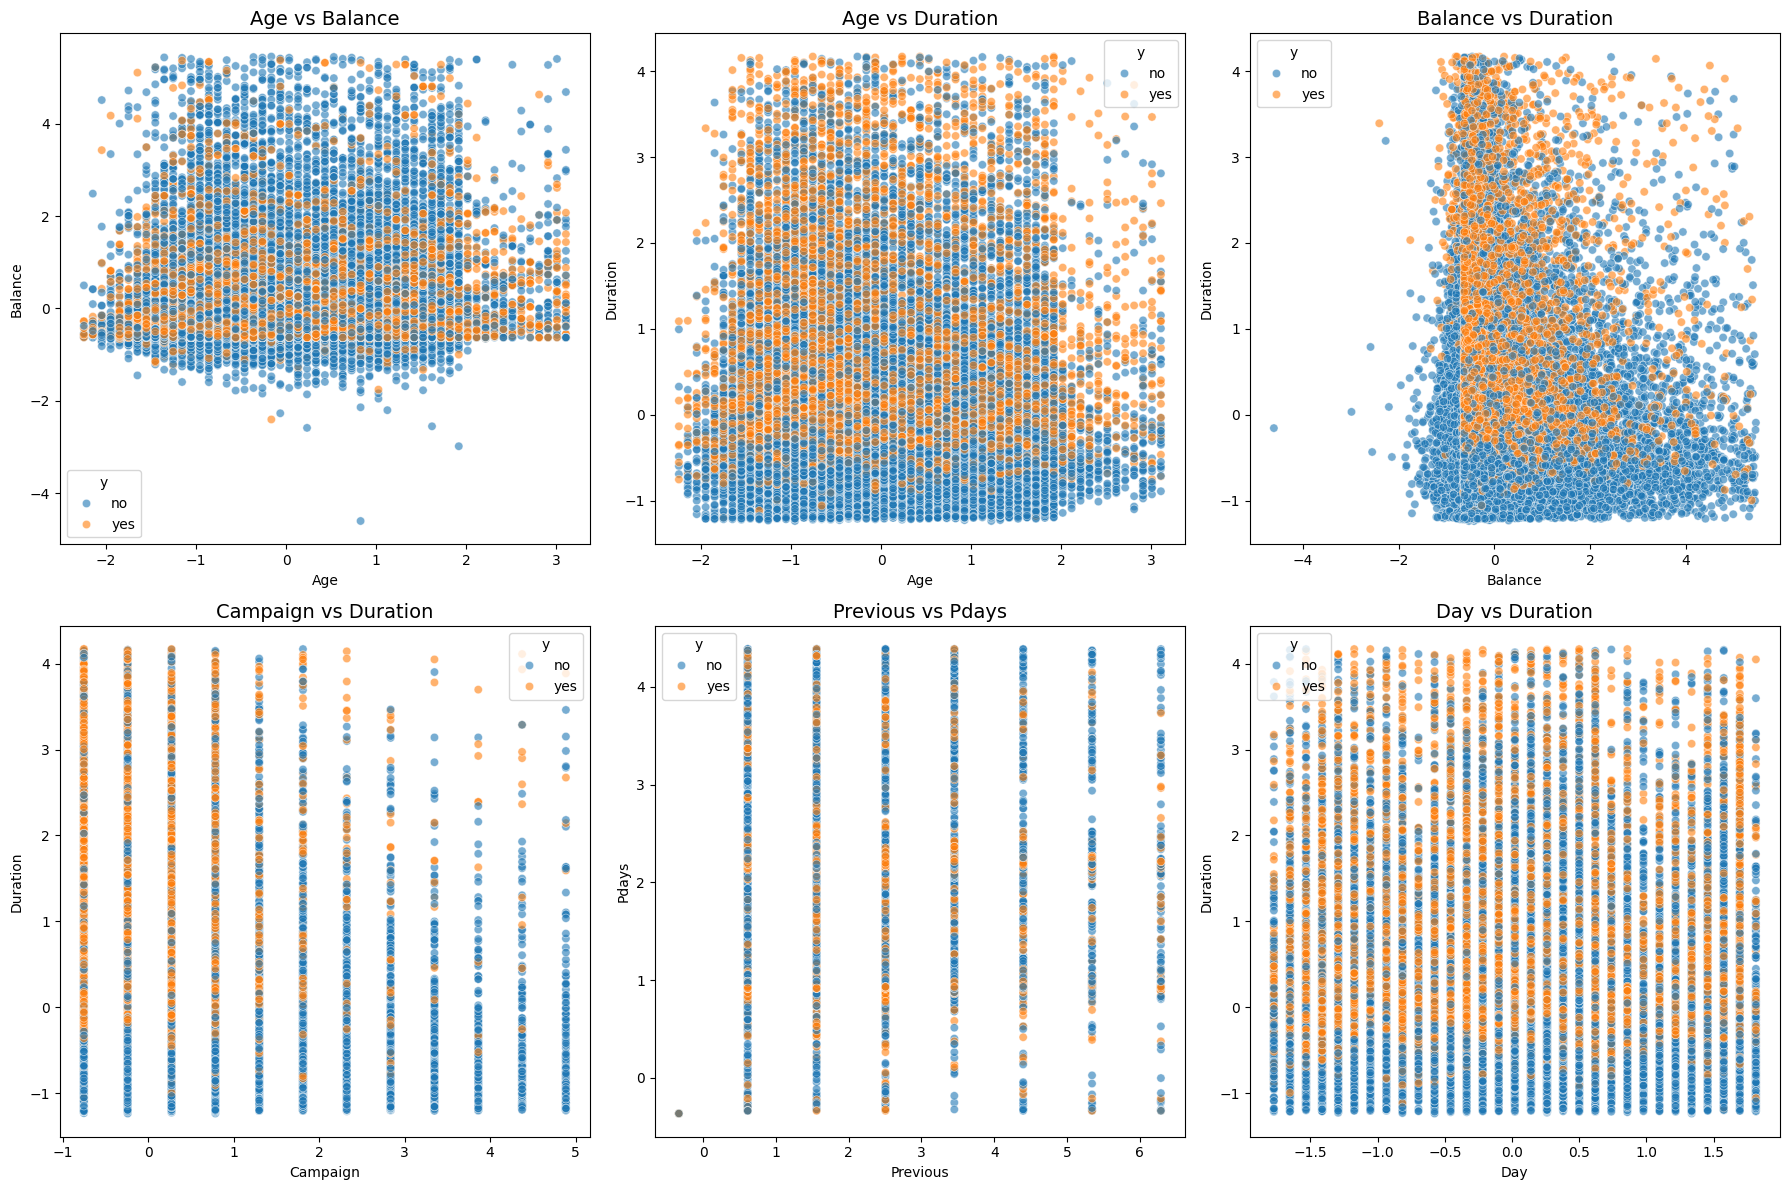

Scatter plots showing relationships between numeric variables.
Points are colored by subscription outcome (y): 'yes' vs 'no'


In [357]:
# Create scatter plots to explore relationships between numeric variables
integer_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create scatter plots for interesting relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define interesting relationships to plot
relationships = [
    ('age', 'balance'),
    ('age', 'duration'),
    ('balance', 'duration'),
    ('campaign', 'duration'),
    ('previous', 'pdays'),
    ('day', 'duration')
]

for i, (x_col, y_col) in enumerate(relationships):
    if i < len(axes):
        # Color by target variable 'y' if you want to see subscription patterns
        sns.scatterplot(data=df_bank, x=x_col, y=y_col, hue='y', ax=axes[i], alpha=0.6)
        axes[i].set_title(f'{x_col.title()} vs {y_col.title()}', fontsize=14)
        axes[i].set_xlabel(x_col.title())
        axes[i].set_ylabel(y_col.title())

plt.tight_layout()
plt.show()

print("Scatter plots showing relationships between numeric variables.")
print("Points are colored by subscription outcome (y): 'yes' vs 'no'")

In [358]:
replacements = {'yes': '1', 'no': '0'}
df_bank['y'] = df_bank['y'].replace(replacements)
df['y'] = df_bank['y'].astype(int)

Creating correlation matrix for original features (before one-hot encoding)...
Converting categorical columns to numeric codes: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


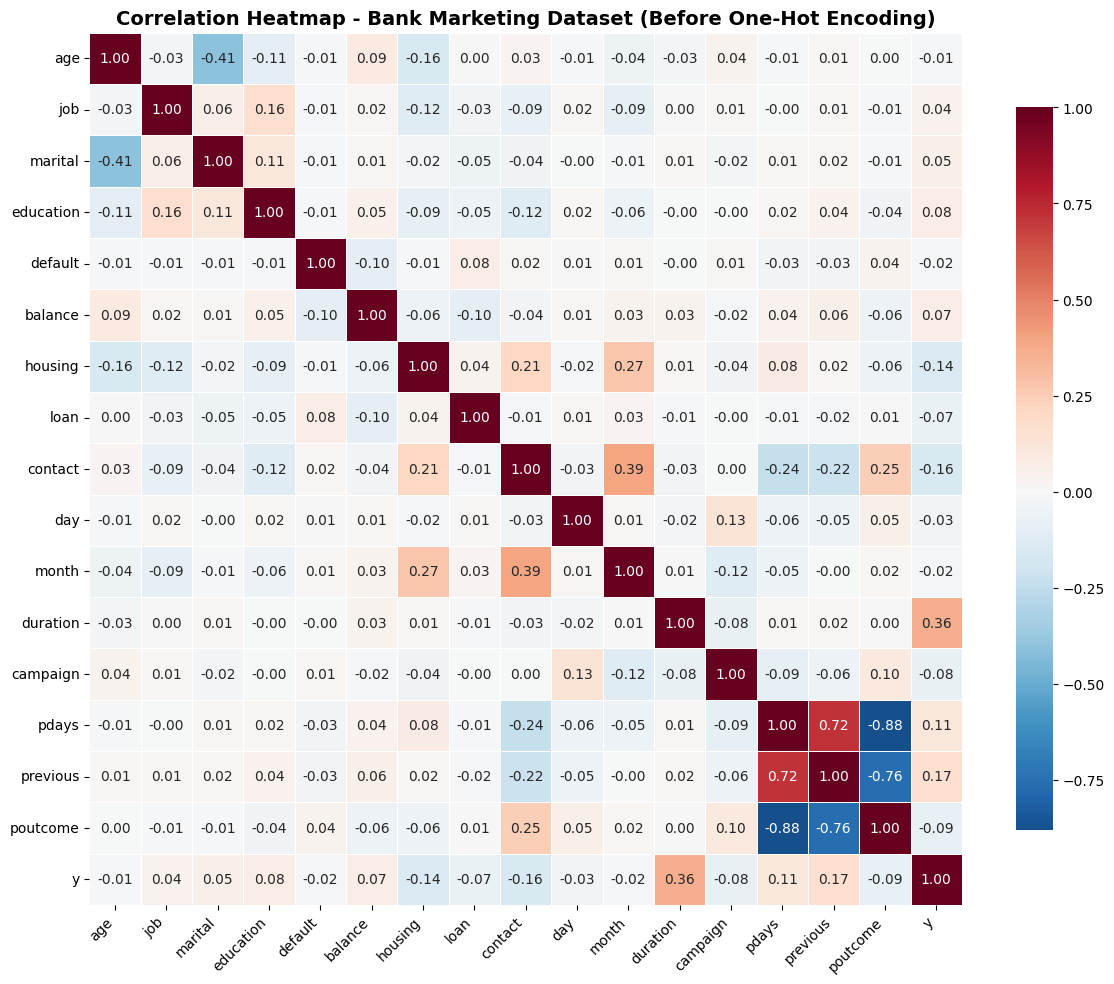


Correlations with target variable 'y' (absolute values, sorted):
  y: 1.000
  duration: 0.362
  previous: 0.168
  contact: 0.156
  housing: 0.144
  pdays: 0.114
  poutcome: 0.087
  campaign: 0.078
  education: 0.075
  loan: 0.070
  balance: 0.067
  marital: 0.054
  job: 0.040
  day: 0.030
  month: 0.020
  default: 0.018
  age: 0.009

Strongest feature-to-feature correlations (absolute value > 0.3):
  pdays <-> poutcome: 0.881
  previous <-> poutcome: 0.760
  pdays <-> previous: 0.720
  age <-> marital: 0.408
  contact <-> month: 0.391


In [ ]:
# Correlation heatmap for bank marketing dataset (BEFORE one-hot encoding)
print("Creating correlation matrix for original features (before one-hot encoding)...")

# Create a copy for correlation analysis
df_bank_corr = df_bank.copy()

# Convert categorical columns to numeric codes for correlation analysis
categorical_cols_for_corr = df_bank_corr.select_dtypes(include=['object']).columns
print(f"Converting categorical columns to numeric codes: {list(categorical_cols_for_corr)}")

for col in categorical_cols_for_corr:
    df_bank_corr[col] = pd.Categorical(df_bank_corr[col]).codes

# Create correlation matrix
correlation_matrix_pre_encoding = df_bank_corr.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_pre_encoding, 
            annot=True,  # Show correlation values
            cmap='RdBu_r', 
            center=0,
            square=True,
            linewidths=0.5,
            fmt='.2f',
            cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap - Bank Marketing Dataset (Before One-Hot Encoding)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Show correlations with target variable
target_corr_pre = correlation_matrix_pre_encoding['y'].abs().sort_values(ascending=False)
# print("\nCorrelations with target variable 'y' (absolute values, sorted):")
for feature, corr in target_corr_pre.items():
    print(f"  {feature}: {corr:.3f}")

# Show strong correlations between features (excluding target)
print("\nStrongest feature-to-feature correlations (absolute value > 0.3):")
strong_corr_pairs = []
for i in range(len(correlation_matrix_pre_encoding.columns)):
    for j in range(i+1, len(correlation_matrix_pre_encoding.columns)):
        if correlation_matrix_pre_encoding.columns[i] != 'y' and correlation_matrix_pre_encoding.columns[j] != 'y':
            corr_val = abs(correlation_matrix_pre_encoding.iloc[i, j])
            if corr_val > 0.3:
                strong_corr_pairs.append((
                    correlation_matrix_pre_encoding.columns[i], 
                    correlation_matrix_pre_encoding.columns[j], 
                    corr_val
                ))

for feat1, feat2, corr_val in sorted(strong_corr_pairs, key=lambda x: x[2], reverse=True):
    print(f"  {feat1} <-> {feat2}: {corr_val:.3f}")

In [360]:
categorical_columns = df_bank.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('y')  # Exclude target variable
df_bank = pd.get_dummies(df_bank, columns=categorical_columns, drop_first=True, dtype=int)
df_bank.head()

age   balance       day  duration  campaign     pdays  previous  y  \
0  1.719131  0.614998 -1.293667  0.132375   -0.7504 -0.364873 -0.333651  0   
1  0.331158 -0.612057 -1.293667 -0.445331   -0.7504 -0.364873 -0.333651  0   
2 -0.759393 -0.627729 -1.293667 -0.839221   -0.7504 -0.364873 -0.333651  0   
3  0.628581  0.245257 -1.293667 -0.755191   -0.7504 -0.364873 -0.333651  0   
4 -0.759393 -0.628309 -1.293667 -0.198493   -0.7504 -0.364873 -0.333651  0   

   job_blue-collar  job_entrepreneur  ...  month_jul  month_jun  month_mar  \
0                0                 0  ...          0          0          0   
1                0                 0  ...          0          0          0   
2                0                 1  ...          0          0          0   
3                1                 0  ...          0          0          0   
4                0                 0  ...          0          0          0   

   month_may  month_nov  month_oct  month_sep  poutcome_other  \
0          1          0          0          0               0   
1          1          0          0          0               0   
2          1          0          0          0               0   
3          1          0          0          0               0   
4          1          0          0          0               0   

   poutcome_success  poutcome_unknown  
0                 0                 1  
1                 0                 1  
2                 0                 1  
3                 0                 1  
4                 0                 1  

[5 rows x 43 columns]

In [361]:
# Run K-means and DBSCAN clustering on bank dataset
X_bank = df_bank.drop('y', axis=1).values.astype(np.float64)

# Ensure target variable is integer
df_bank['y'] = pd.to_numeric(df_bank['y'], errors='coerce').astype(int)
y_true_bank = df_bank['y'].values

print(f"Bank dataset shape for clustering: {X_bank.shape}")
print(f"Target variable dtype: {y_true_bank.dtype}")
print(f"Target distribution: {np.bincount(y_true_bank)}")

# Apply K-means clustering
k_clusters = 20  
kmeans_bank = KMeans(k=k_clusters, max_iter=100)
kmeans_bank.fit(X_bank)

# Get K-means labels
distances_bank = np.linalg.norm(X_bank[:, np.newaxis] - kmeans_bank.centroids, axis=2)
labels_kmeans_bank = np.argmin(distances_bank, axis=1)

# Apply DBSCAN clustering
db_bank = DBSCAN(eps=0.5, min_samples=50)  # Adjusted parameters for bank data
labels_dbscan_bank = db_bank.fit_predict(X_bank)

# Calculate metrics
n_noise_bank = int((labels_dbscan_bank == -1).sum())
unique_labels_bank = set(labels_dbscan_bank)
n_clusters_db_bank = len(unique_labels_bank - {-1})

print(f"\nClustering Results:")
print(f"K-means: {len(set(labels_kmeans_bank))} clusters")
print(f"DBSCAN: {n_clusters_db_bank} clusters and {n_noise_bank} noise points")

# Compute silhouette scores
S_kmeans_bank = silhouette_score(X_bank, labels_kmeans_bank)
print(f"K-means Silhouette Score: {S_kmeans_bank:.6f}")

# DBSCAN silhouette score (excluding noise points)
mask_bank = labels_dbscan_bank != -1
if n_clusters_db_bank >= 2 and mask_bank.sum() > 0:
    S_dbscan_bank = silhouette_score(X_bank[mask_bank], labels_dbscan_bank[mask_bank])
    print(f"DBSCAN Silhouette Score (excluding noise): {S_dbscan_bank:.6f}")
else:
    print("DBSCAN: Cannot compute silhouette score (need at least 2 clusters excluding noise)")

# Calculate NMI with true labels
from sklearn.metrics import normalized_mutual_info_score

nmi_kmeans_bank = normalized_mutual_info_score(y_true_bank, labels_kmeans_bank)
nmi_dbscan_bank = normalized_mutual_info_score(y_true_bank, labels_dbscan_bank)

print(f"\nNormalized Mutual Information with true labels:")
print(f"K-means NMI: {nmi_kmeans_bank:.6f}")
print(f"DBSCAN NMI: {nmi_dbscan_bank:.6f}")

Bank dataset shape for clustering: (40209, 42)
Target variable dtype: int64
Target distribution: [36155  4054]


Clustering Progress:  82%|████████▏ | 82/100 [00:02<00:00, 33.81it/s]




Clustering Results:
K-means: 18 clusters
DBSCAN: 0 clusters and 40209 noise points
K-means Silhouette Score: 0.090219
DBSCAN: Cannot compute silhouette score (need at least 2 clusters excluding noise)

Normalized Mutual Information with true labels:
K-means NMI: 0.036035
DBSCAN NMI: 0.000000
K-means Silhouette Score: 0.090219
DBSCAN: Cannot compute silhouette score (need at least 2 clusters excluding noise)

Normalized Mutual Information with true labels:
K-means NMI: 0.036035
DBSCAN NMI: 0.000000


PCA explained variance ratio: [0.18365474 0.11595046]
Total variance explained: 0.300


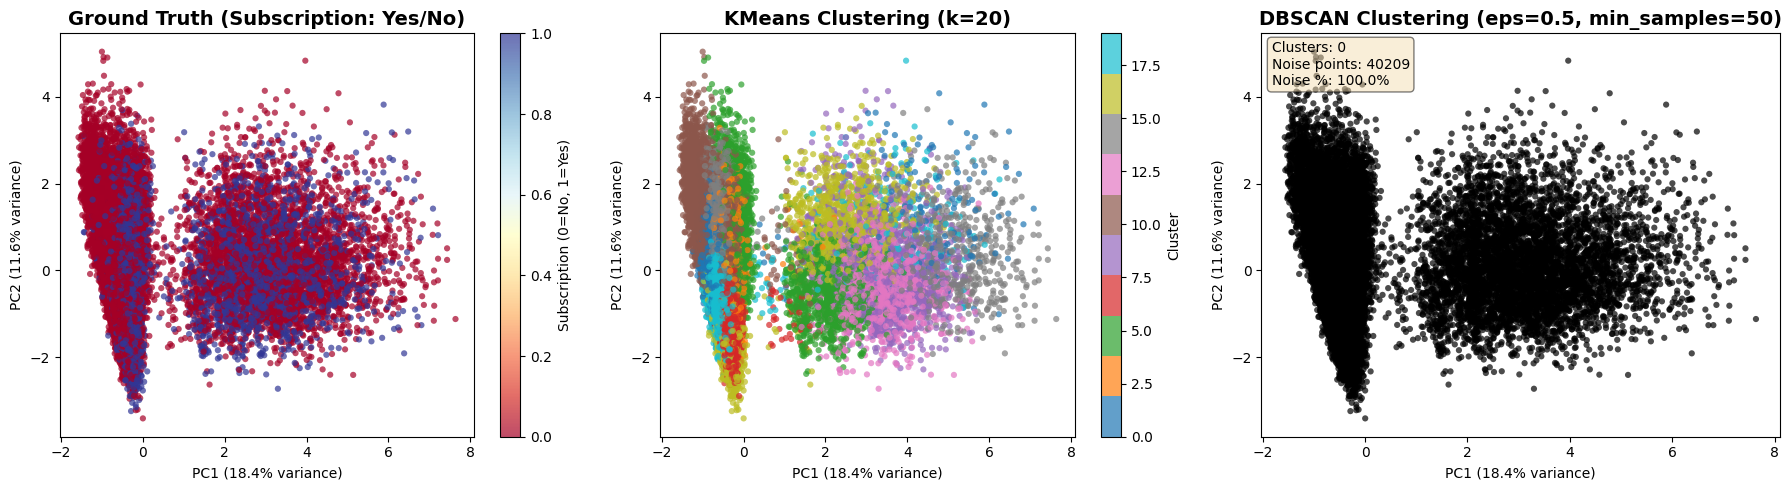


Bank Dataset Clustering Summary:
  Ground Truth: 2 classes (subscription: yes/no)
  K-means: 18 clusters
  DBSCAN: 0 clusters + 40209 noise points (100.0%)
  PCA variance captured: 30.0%


In [362]:
# Visualize bank dataset clustering results using PCA for 2D representation
from sklearn.decomposition import PCA

# Apply PCA to reduce bank data to 2D for visualization
pca_bank = PCA(n_components=2)
X_bank_2d = pca_bank.fit_transform(X_bank)

print(f"PCA explained variance ratio: {pca_bank.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_bank.explained_variance_ratio_):.3f}")

# Create visualization similar to circles dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original data with true labels (subscription: yes/no)
ax1 = axes[0]
scatter1 = ax1.scatter(X_bank_2d[:, 0], X_bank_2d[:, 1], c=y_true_bank, 
                      cmap='RdYlBu', s=20, alpha=0.7, edgecolors='none')
ax1.set_title('Ground Truth (Subscription: Yes/No)', fontsize=14, fontweight='bold')
ax1.set_xlabel(f'PC1 ({pca_bank.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca_bank.explained_variance_ratio_[1]:.1%} variance)')
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Subscription (0=No, 1=Yes)')

# KMeans clustering results
ax2 = axes[1]
scatter2 = ax2.scatter(X_bank_2d[:, 0], X_bank_2d[:, 1], c=labels_kmeans_bank, 
                      cmap='tab10', s=20, alpha=0.7, edgecolors='none')
ax2.set_title(f'KMeans Clustering (k={k_clusters})', fontsize=14, fontweight='bold')
ax2.set_xlabel(f'PC1 ({pca_bank.explained_variance_ratio_[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({pca_bank.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

# DBSCAN clustering results
ax3 = axes[2]
# Create color map - noise points in black
unique_labels_db_bank = set(labels_dbscan_bank)
colors_db_bank = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_db_bank))]

for k, col in zip(unique_labels_db_bank, colors_db_bank):
    if k == -1:
        # Black for noise
        col = [0, 0, 0, 1]
    
    class_member_mask = (labels_dbscan_bank == k)
    xy = X_bank_2d[class_member_mask]
    ax3.scatter(xy[:, 0], xy[:, 1], c=[col], s=20, alpha=0.7, edgecolors='none', 
                label='Noise' if k == -1 else f'Cluster {k}')

ax3.set_title(f'DBSCAN Clustering (eps={db_bank.eps}, min_samples={db_bank.min_samples})', 
              fontsize=14, fontweight='bold')
ax3.set_xlabel(f'PC1 ({pca_bank.explained_variance_ratio_[0]:.1%} variance)')
ax3.set_ylabel(f'PC2 ({pca_bank.explained_variance_ratio_[1]:.1%} variance)')

# Add summary text
textstr = f'Clusters: {n_clusters_db_bank}\nNoise points: {n_noise_bank}\nNoise %: {n_noise_bank/len(X_bank)*100:.1f}%'
ax3.text(0.02, 0.98, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nBank Dataset Clustering Summary:")
print(f"  Ground Truth: 2 classes (subscription: yes/no)")
print(f"  K-means: {len(set(labels_kmeans_bank))} clusters")
print(f"  DBSCAN: {n_clusters_db_bank} clusters + {n_noise_bank} noise points ({n_noise_bank/len(X_bank)*100:.1f}%)")
print(f"  PCA variance captured: {sum(pca_bank.explained_variance_ratio_):.1%}")